In [1]:
import numpyro

numpyro.enable_x64()
numpyro.set_platform('gpu')

In [2]:
import arviz as az
from leaguedata.plot import plot_history, plot_compare_plotly
from leaguedata.model import generate_coinflip_history, generate_nasty_loser_q, generate_obvious_loser_q

# Obvious LoserQ

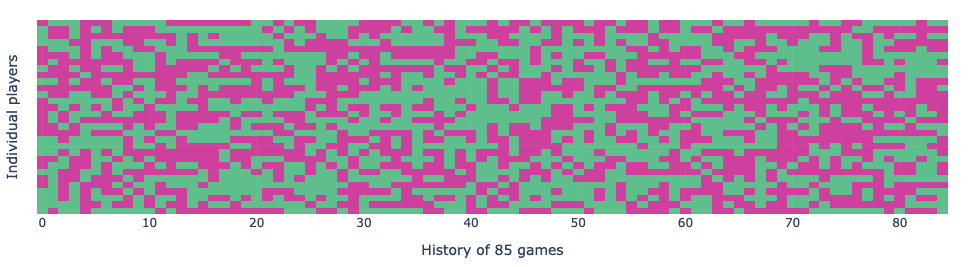

In [3]:
mock_history = generate_obvious_loser_q(number_of_players=30, number_of_games=85)
plot_history(mock_history, save_to='docs/loserQ/assets/validation_obvious.json');

In [4]:
from leaguedata.inference import fit_history_with_dmc

mock_history = generate_obvious_loser_q(number_of_players=400, number_of_games=85)
dict_of_id = fit_history_with_dmc(mock_history, num_chains=4)
compare_dataframe = az.compare(dict_of_id)
compare_dataframe

sample: 100%|██████████| 2000/2000 [00:11<00:00, 171.69it/s]


rank      elpd_loo      p_loo   elpd_diff    weight         se  \
4 games     0 -22932.848168  16.466857    0.000000  0.940913  45.416046   
5 games     1 -22946.438634  32.724216   13.590466  0.000000  45.639896   
6 games     2 -22967.295466  63.971036   34.447298  0.000000  45.831222   
3 games     3 -23078.802118   8.958623  145.953950  0.003097  40.480829   
2 games     4 -23233.709901   5.517614  300.861733  0.050115  34.527417   
1 games     5 -23367.450967   3.249688  434.602799  0.000000  23.210238   
0 games     6 -23566.266380   2.426335  633.418212  0.005875   3.413052   

               dse  warning scale  
4 games   0.000000    False   log  
5 games   4.816398    False   log  
6 games   8.244284    False   log  
3 games  18.541642    False   log  
2 games  27.262887    False   log  
1 games  32.933650    False   log  
0 games  45.085726    False   log

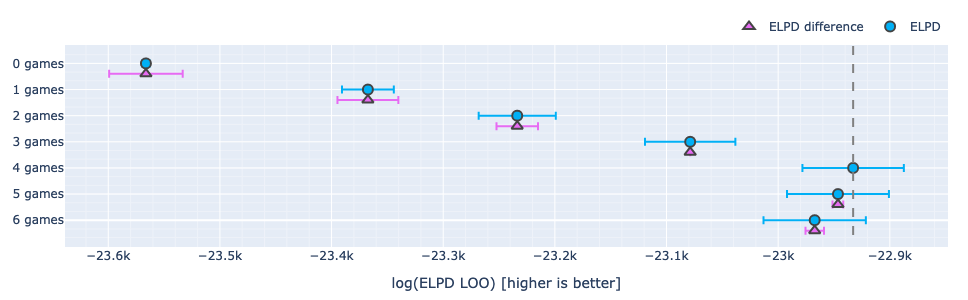

In [5]:
plot_compare_plotly(compare_dataframe, save_to='docs/loserQ/assets/validation_obvious_compare.json');

In [6]:
best_id = dict_of_id['4 games']

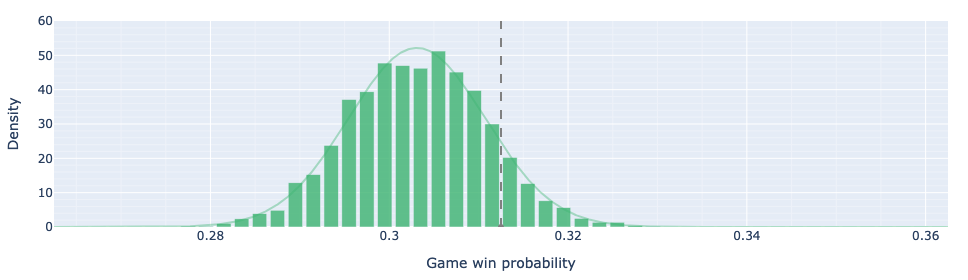

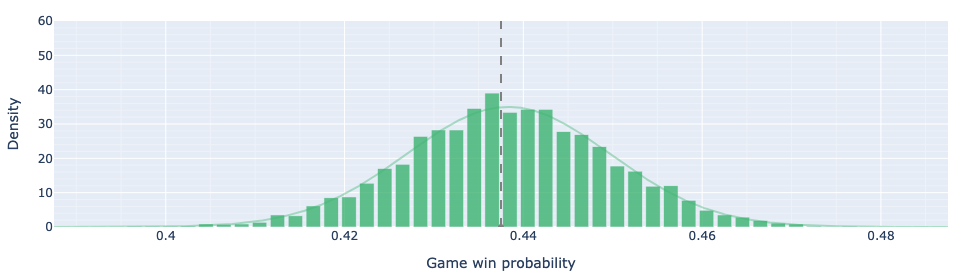

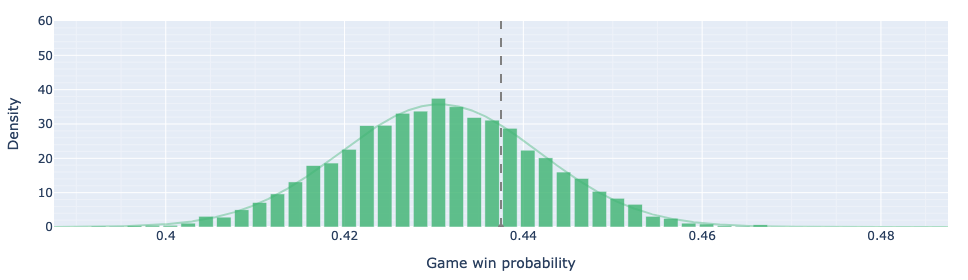

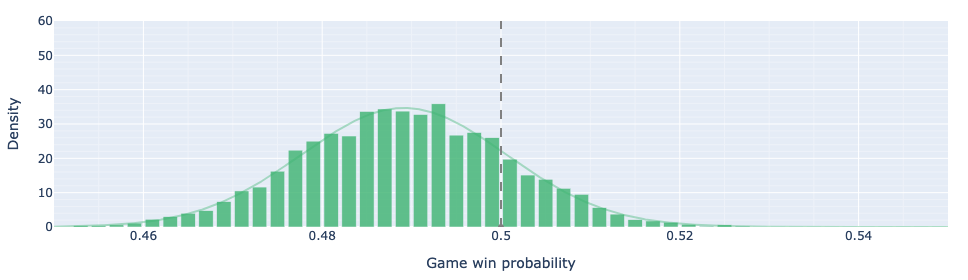

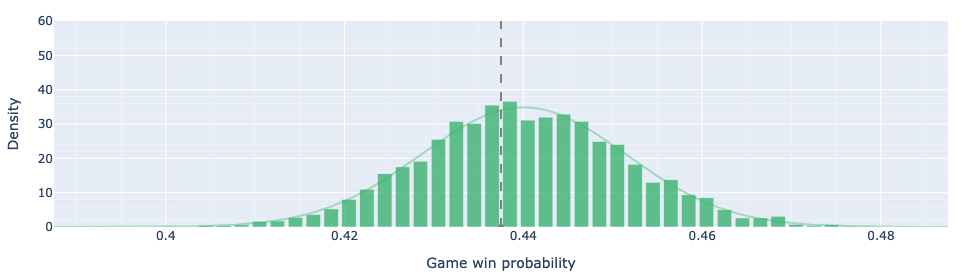

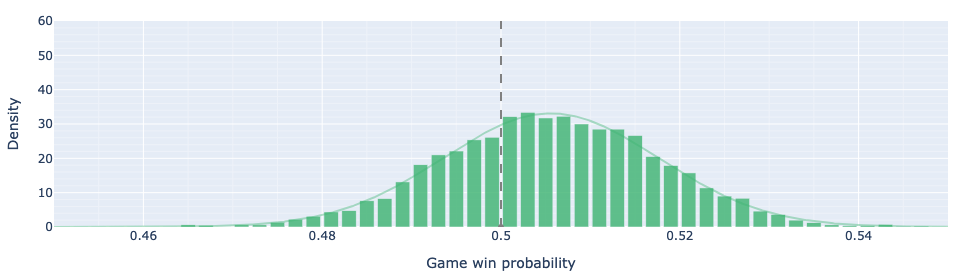

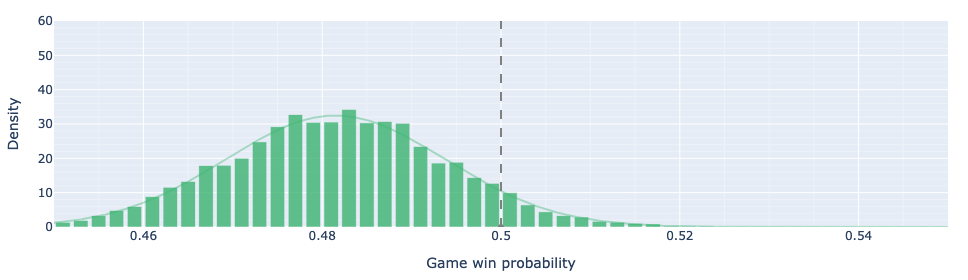

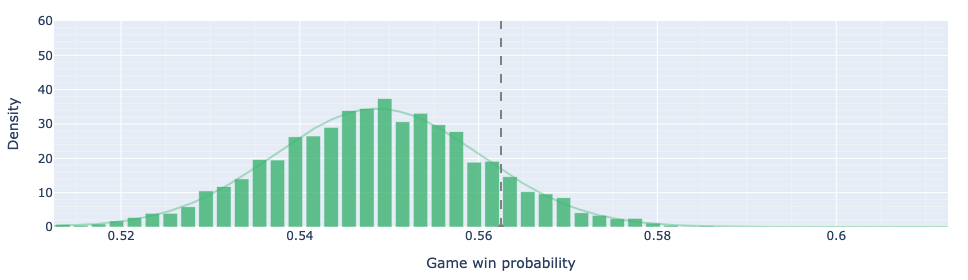

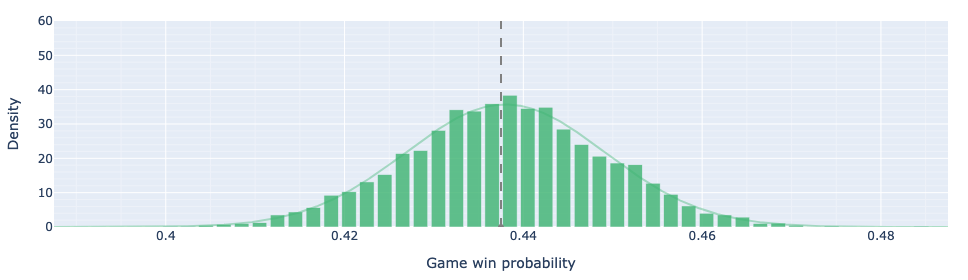

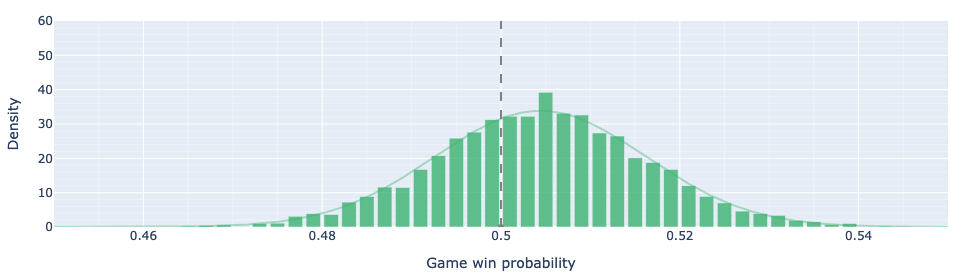

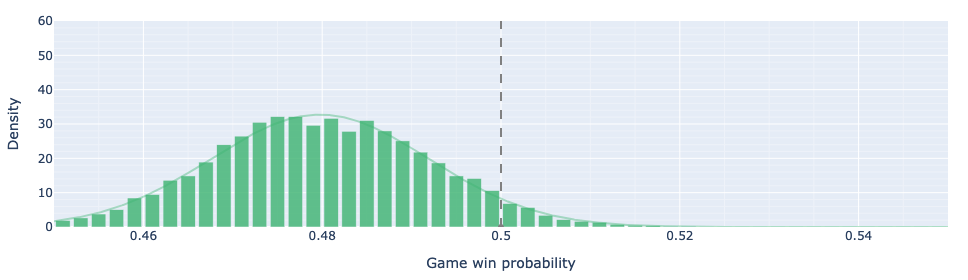

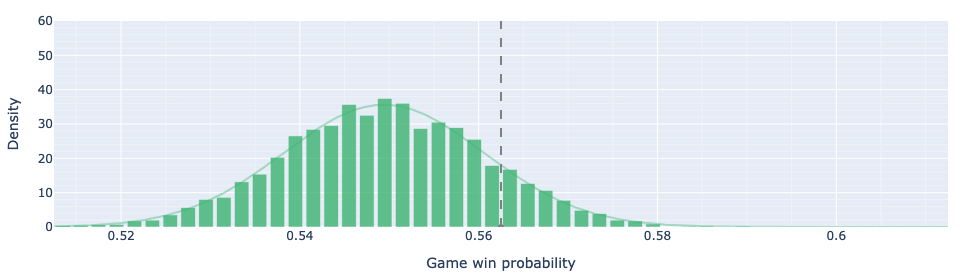

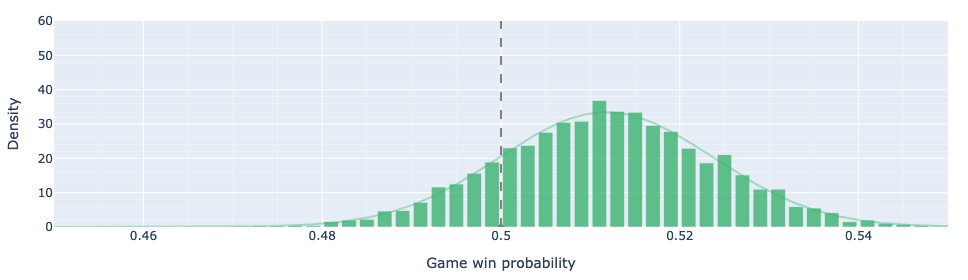

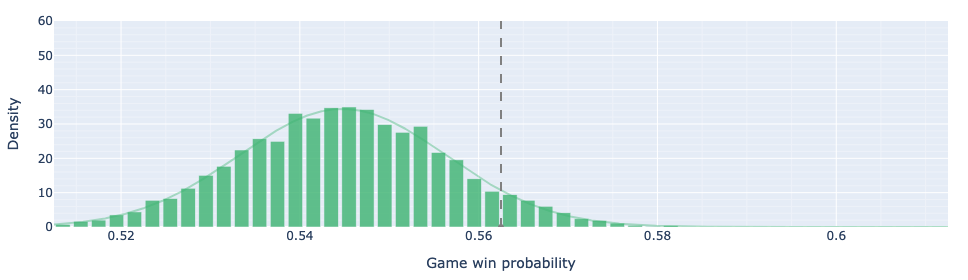

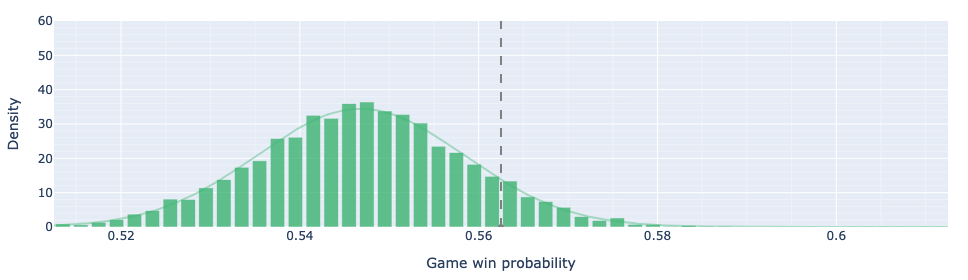

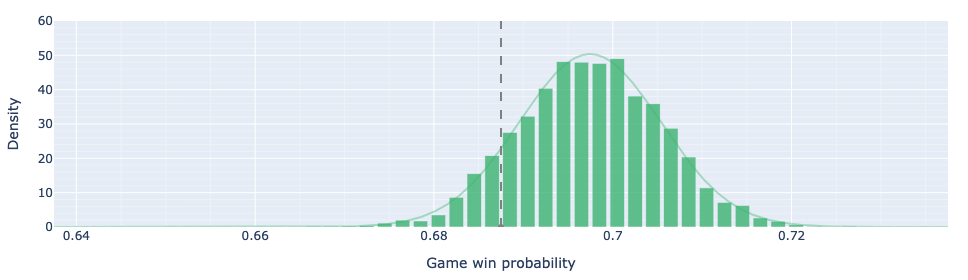

In [15]:
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from scipy.stats import norm
import numpy as np
import pandas as pd 
import jax.numpy as jnp
import matplotlib.pyplot as plt
from leaguedata.inference import DTMCModel
from chainconsumer import ChainConsumer, Chain, Truth

best_id = dict_of_id['4 games']
markov_util = DTMCModel(4)
samples = np.asarray(az.extract(best_id).proba)

probs = jnp.empty((2 ** 4))
importance = 0.5

probs_keys = {
    0.: 0.5 - 0.375 * importance,
    0.25: 0.5 - 0.125 * importance,
    0.5: 0.5,
    0.75: 0.5 + 0.125 * importance,
    1.: 0.5 + 0.375 * importance
}

for i, state in enumerate(markov_util.get_states()):
    probs = probs.at[i].set(probs_keys[sum(state) / 4])

probs = np.asarray(probs)
results = np.asarray(az.extract(best_id).proba)
# List of data and colors
titles = [''.join(["W" if win else "L" for win in state]) + '-> W' for state in markov_util.get_states()]
colors = ['rgba(60, 179, 113, 0.8)']*16  #'rgba(199, 21, 133, 0.8)'
colors_density = ['rgba(60, 179, 113, 0.4)']*16   #'rgba(199, 21, 133, 0.4)'

for i, (data, true_proba, title, color, color_density) in enumerate(zip(results, probs, titles, colors, colors_density)):


    x_min, x_max = max(true_proba - 0.05, 0), min(true_proba + 0.05, 1)
    fig = go.Figure()#make_subplots(rows=2, cols=2, subplot_titles=titles, shared_xaxes='all', shared_yaxes='all',)
    # Compute histogram
    hist = np.histogram(data, bins=50, range=(x_min, x_max), density=True)
    bins = hist[1]
    bin_centers = (bins[:-1] + bins[1:]) / 2

    data = np.asarray(data)
    
    # Fit a gaussian
    mu, sigma = norm.fit(data)
    pdf = norm.pdf(np.linspace(x_min, x_max, 1000), mu, sigma)

    # Create histogram trace
    hist_trace = go.Bar(x=bin_centers, y=hist[0], showlegend=False, marker_color=color, name=f'Hist {i+1}')
    
    # Create gaussian fit trace
    fit_trace = go.Scatter(x=np.linspace(x_min, x_max, 1000), y=pdf, mode='lines', line=dict(color=color_density),
                           text=[f'Mean: {mu:.2f}<br>Sigma: {sigma:.2f}']*len(bin_centers),
                           hoverinfo='text+x+y')

    ref_trace = go.Line(
        x=[true_proba, true_proba], 
        y=[0, 400], 
        line=dict(color="grey", width=2, dash="dash")
    )
    
    # Add traces to the subplot
    fig.add_trace(hist_trace)#, row=row, col=col)
    fig.add_trace(fit_trace)#, row=row, col=col)
    fig.add_trace(ref_trace)#, row=row, col=col)

    
    fig.update_xaxes(range=[x_min, x_max], title='Game win probability', 
        showgrid=True, minor=dict(showgrid=True))
    fig.update_yaxes(range=[0., 60.], title='Density', 
        showgrid=True, minor=dict(showgrid=True))
    
    # Update layout
    fig.update_layout(
        margin=dict(l=20, r=20, t=20, b=20),
        #title_text=titles[i], title_x=0.5, title_y=0.95,
        height=280, width=320, showlegend=False,
    )
    
    # Show plot
    fig.show()
    
    with open(f'docs/loserQ/assets/validation_transition_probas_{i}.json', "w") as f:
        f.write(fig.to_json())

# Nasty LoserQ

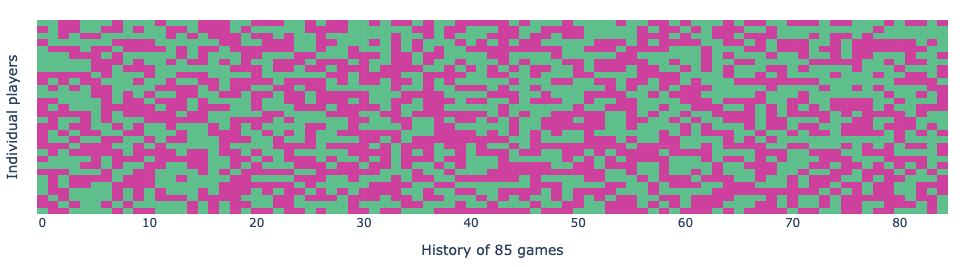

In [16]:
mock_history = generate_nasty_loser_q(number_of_players=30, number_of_games=85)
plot_history(mock_history, save_to='docs/loserQ/assets/validation_nasty.json');

In [ ]:
from leaguedata.inference import fit_history_with_dmc

mock_history = generate_nasty_loser_q(number_of_players=400, number_of_games=85)
dict_of_id = fit_history_with_dmc(mock_history)
compare_dataframe = az.compare(dict_of_id)
compare_dataframe

sample:  55%|█████▍    | 1095/2000 [06:34<04:59,  3.02it/s]

In [ ]:
plot_compare_plotly(compare_dataframe, save_to='docs/loserQ/assets/validation_nasty_compare.json');

In [ ]:
from leaguedata.inference import fit_history_with_dmc

mock_history = generate_coinflip_history(number_of_players=400, number_of_games=85)
dict_of_id = fit_history_with_dmc(mock_history)
compare_dataframe = az.compare(dict_of_id)
compare_dataframe

In [ ]:
plot_compare_plotly(compare_dataframe, save_to='docs/loserQ/assets/validation_coinflip_compare.json');